Sources:

https://www.itl.nist.gov/div898/handbook/ppc/section5/ppc51.htm

https://www.itl.nist.gov/div898/handbook/pmc/section1/pmc16.htm

https://support.minitab.com/en-us/minitab/19/help-and-how-to/quality-and-process-improvement/capability-analysis/how-to/capability-analysis/normal-capability-analysis/methods-and-formulas/overall-capability/#cpm

## Preparation

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\An PC\\jupyter\\eda'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from utils import datasets
from utils import calculations
from utils.plotting import show_and_save_plot
from plots import (run_sequence_plot, histogram, lag_plot, probability_plot, qq_plot,
                   block_plot, box_plot, doe_scatter_plot, doe_scatter_matrix,
                   doe_statistic_plot, doe_statistic_matrix)

---

# Furnace Case Study
This case study analyzes a furnace oxide growth process.

The case study is broken down into the following steps.

1. [Background and Data](#background)
2. [Initial Analysis of Response Variable](#initial_analysis)
3. [Identify Sources of Variation](#sources_of_variation)
4. [Analysis of Variance](#anova)
5. [Final Conclusions](#conclusions)
    
---

## <a name="background"></a>Background and Data
### Introduction
In a semiconductor manufacturing process flow, we have a step whereby we grow an oxide film on the silicon wafer using a furnace. In this step, a cassette of wafers is placed in a quartz "boat" and the boats are placed in the furnace. The furnace can hold four boats. A gas flow is created in the furnace and it is brought up to temperature and held there for a specified period of time (which corresponds to the desired oxide thickness). This study was conducted to determine if the process was stable and to characterize sources of variation so that a process control strategy could be developed.

### Goal
The goal of this study is to determine if this process is capable of consistently growing oxide films with a thickness of $560 \pm 100 \text{ Angstroms}$. An additional goal is to determine important sources of variation for use in the development of a process control strategy. 

### Data source
https://www.itl.nist.gov/div898/handbook/datasets/FURNACE.DAT

### Process Model
In the picture below we are modeling this process with one output (film thickness) that is influenced by four controlled factors (gas flow, pressure, temperature and time) and two uncontrolled factors (run and zone). The four controlled factors are part of our recipe and will remain constant throughout this study. We know that there is run-to-run variation that is due to many different factors (input material variation, variation in consumables, etc.). We also know that the different zones in the furnace have an effect. A zone is a region of the furnace tube that holds one boat. There are four zones in these tubes. The zones in the middle of the tube grow oxide a little bit differently from the ones on the ends. In fact, there are temperature offsets in the recipe to help minimize this problem.

![](https://www.itl.nist.gov/div898/handbook/ppc/section5/Furnace/gifs/furnace1.gif)

### Sensitivity Model
The sensitivity model for this process is fairly straightforward and is given in the figure below. The effects of the machine are mostly related to the preventative maintenance (PM) cycle. We want to make sure the quartz tube has been cleaned recently, the mass flow controllers are in good shape and the temperature controller has been calibrated recently. The same is true of the measurement equipment where the thickness readings will be taken. We want to make sure a [gauge study](https://www.itl.nist.gov/div898/handbook/mpc/section4/mpc4.htm) has been performed. For material, the incoming wafers will certainly have an effect on the outgoing thickness as well as the quality of the gases used. Finally, the recipe will have an effect including gas flow, temperature offset for the different zones, and temperature profile (how quickly we raise the temperature, how long we hold it and how quickly we cool it off).

![](https://www.itl.nist.gov/div898/handbook/ppc/section5/Furnace/gifs/furnace2.gif)

### Sampling Plan
Given our goal statement and process modeling, we can now define a sampling plan. The primary goal is to determine if the process is capable. This just means that we need to monitor the process over some period of time and compare the estimates of process location and spread to the specifications. An additional goal is to identify sources of variation to aid in setting up a process control strategy. Some obvious sources of variation are incoming wafers, run-to-run variability, variation due to operators or shift, and variation due to zones within a furnace tube. One additional constraint that we must work under is that this study should not have a significant impact on normal production operations.

Given these constraints, the following sampling plan was selected. It was decided to monitor the process for one day (three shifts). Because this process is operator independent, we will not keep shift or operator information but just record run number. For each run, we will randomly assign cassettes of wafers to a zone. We will select two wafers from each zone after processing and measure two sites on each wafer. This plan should give reasonable estimates of run-to-run variation and within zone variability as well as good overall estimates of process location and spread.

We are expecting readings around 560 Angstroms. We would not expect many readings above 700 or below 400. The measurement equipment is accurate to within 0.5 Angstroms which is well within the accuracy needed for this study.

### Data
The following are the data that were collected for this study. 

In [3]:
df = datasets.load_furnace()
df

,RUN,ZONE,WAFER,THICKNESS
0,1,1,1,546
1,1,1,2,540
2,1,2,1,566
3,1,2,2,564
4,1,3,1,577
...,...,...,...,...
163,21,2,2,602
164,21,3,1,598
165,21,3,2,616
166,21,4,1,580


---

## <a name="initial_analysis"></a>Initial Analysis of Response Variable
### Initial Plots of Response Variable
The initial step is to assess data quality and to look for anomalies. This is done by generating a normal probability plot, a histogram, and a box plot. For convenience, these are generated on a single page.

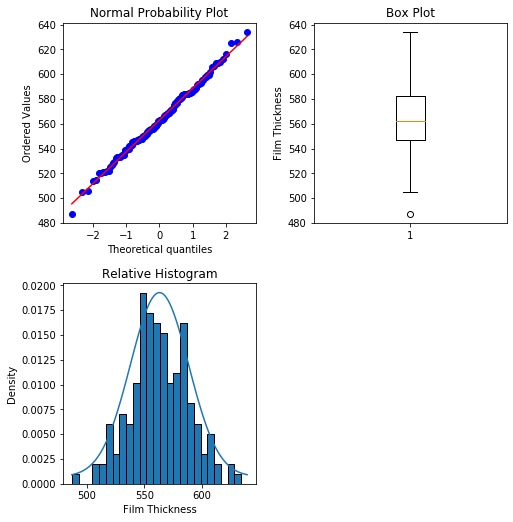

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2,
                         gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0.3,
                                 },
                         figsize=(7, 8))
prob, box = axes[0]
hist, _ = axes[1]
    
probability_plot(df["THICKNESS"], title="Normal Probability Plot", ax=prob, show=False)

histogram(df["THICKNESS"], bins=25, x_label="Film Thickness", y_label="Density",
          title="Relative Histogram", ax=hist, plot_pdf=True, show=False, density=True)

box.boxplot(df["THICKNESS"])
box.set_ylabel("Film Thickness")
box.set_title("Box Plot")

_.axis("off")

plt.show()

### Conclusions From the Plots
We can make the following conclusions based on these initial plots.


* The box plot indicates one outlier. However, this outlier is only slightly smaller than the other numbers.


* The normal probability plot and the histogram (with an overlaid normal density) indicate that this data set is reasonably approximated by a normal distribution. 

### Parameter Estimates
Parameter estimates for the film thickness are as follows. 

In [5]:
mean = df["THICKNESS"].mean()
std = df["THICKNESS"].std()
n = len(df["THICKNESS"])

confidence_interval_of_mean = stats.t.interval(0.95, n-1, mean, std/np.sqrt(n))

In [6]:
def confidence_interval_of_std(alpha, dof, std):
    lower_limit = std * np.sqrt(dof/stats.chi2.ppf(1-alpha/2, dof))
    upper_limit = std * np.sqrt(dof/stats.chi2.ppf(alpha/2, dof))
    
    return lower_limit, upper_limit

In [7]:
print("Mean =", mean, ", Confidence Interval =", confidence_interval_of_mean)
print("Standard Deviation =", std, ", Confidence Interval",
      confidence_interval_of_std(0.05, n-1, std))

Mean = 563.0357142857143 , Confidence Interval = (559.169162782702, 566.9022657887267)
Standard Deviation = 25.38467944223335 , Confidence Interval (22.929667837375742, 28.433063497684035)


### Quantiles
Quantiles for the film thickness are summarized in the following table. 

In [8]:
percentages = np.array([100, 99.5, 97.5, 90, 75, 50, 25, 10, 2.5, 0.5, 0])
for p in percentages:
    print("{:>5}%    ".format(p), df["THICKNESS"].quantile(p/100, interpolation="midpoint"))

100.0%     634.0
 99.5%     630.0
 97.5%     611.0
 90.0%     594.0
 75.0%     582.5
 50.0%     562.5
 25.0%     546.5
 10.0%     533.0
  2.5%     517.5
  0.5%     496.0
  0.0%     487.0


### Capability Analysis
From the above preliminary analysis, it looks reasonable to proceed with the [capability analysis](https://www.itl.nist.gov/div898/handbook/ppc/section4/ppc46.htm).

![](https://www.itl.nist.gov/div898/handbook/ppc/section5/Furnace/gifs/capabili.jpg)

The lower specification limit is 460, the upper specification limit is 660, and the target specification is 560.

### Percent Defective
We determine the percent defective (i.e., the number of items outside the specification limits) as follows. 

In [9]:
lsl, usl, target = 460, 660, 560

In [10]:
print("Percent below LSL:")

actual_percent_1 = len(df[df["THICKNESS"]<lsl])/len(df)*100
print("+ Actual:", actual_percent_1)

theoretical_percent_1 = 100*stats.norm.cdf(lsl, mean, std)
print("+ Theoretical:", theoretical_percent_1, "\n")

print("Percent above USL:")

actual_percent_2 = len(df[df["THICKNESS"]>usl])/len(df)*100
print("+ Actual:", actual_percent_2)

theoretical_percent_2 = 100*(1-stats.norm.cdf(usl, mean, std))
print("+ Theoretical:", theoretical_percent_2, "\n")

print("Combined percent below LSL and above USL:")
print("+ Actual:", actual_percent_1+actual_percent_2)
print("+ Theoretical:", theoretical_percent_1+theoretical_percent_2)

Percent below LSL:
+ Actual: 0.0
+ Theoretical: 0.0024644564783832842 

Percent above USL:
+ Actual: 0.0
+ Theoretical: 0.006678116636316123 

Combined percent below LSL and above USL:
+ Actual: 0.0
+ Theoretical: 0.009142573114699407


$$\text{Theoretical percent below LSL = }100\times\Phi\left(\frac{LSL-\bar{x}}{s}\right)$$
$$\text{Theoretical percent above USL = }100\times\left[1-\Phi\left(\frac{USL-\bar{x}}{s}\right)\right]$$

The value $\Phi$ denotes the normal cumulative distribution function, $\bar{x}$ the sample mean, and *s* the sample standard deviation.

### Introduction to Capability Index Statistics
There are several statistics that can be used to measure the capability of a process:  $C_\mathrm{p}$, $C_\mathrm{pk}$, and $C_\mathrm{pm}$.

Most capability indices estimates are valid only if the sample size used is "large enough". Large enough is generally thought to be about 50 independent data values. 

The $C_\mathrm{p}$, $C_\mathrm{pk}$, and $C_\mathrm{pm}$ statistics assume that the population of data values is normally distributed. Assuming a two-sided specification, if $\mu$ and $\sigma$ are the mean and standard deviation, respectively, of the normal data and *USL*, *LSL*, and *T* are the upper and lower specification limits and the target value, respectively, then the population capability indices are defined as follows.

#### Definitions of various process capability indices
$$C_\mathrm{p}=\frac{USL-LSL}{6\sigma}$$
$$C_\mathrm{pk}=\min\left(\frac{USL-\mu}{3\sigma},\frac{\mu-LSL}{3\sigma}\right)$$
$$C_\mathrm{pm}=\frac{USL-LSL}{6\sqrt{\sigma^2+(\mu-T)^2}}$$

#### Sample estimates of capability indices
Sample estimators for these indices are given below. (Estimators are indicated with a "hat" over them).
$$\hat{C}_\mathrm{p}=\frac{USL-LSL}{6s}$$
$$\hat{C}_\mathrm{pk}=\min\left(\frac{USL-\bar{x}}{3s},\frac{\bar{x}-LSL}{3s}\right)$$
$$\hat{C}_\mathrm{pm}=\frac{USL-LSL}{6\sqrt{s^2+(\bar{x}-T)^2}}$$

In [11]:
def Cp(series, LSL, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    
    return np.abs(USL-LSL) / (6*std)


def Cpk(series, LSL, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    
    return min(np.abs(USL-mean), np.abs(mean-LSL)) / (3*std)


def Cpm(series, LSL, USL, target):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    
    numerator = np.abs(USL-LSL)
    denominator = 6 * np.sqrt(std**2 + (mean-target)**2)
    
    return numerator / denominator

#### Plot showing $C_\mathrm{p}$ for varying process widths
To get an idea of the value of the $C_\mathrm{p}$ statistic for varying process widths, consider the following plot.

![](https://www.itl.nist.gov/div898/handbook/pmc/section1/gifs/plotcp_r.gif)

#### One-sided specifications and the corresponding capability indices
We have discussed the situation with two specification limits, the *USL* and *LSL*. This is known as the bilateral or two-sided case. There are many cases where only the lower or upper specifications are used. Using one spec limit is called unilateral or one-sided. The corresponding capability indices are
	
$$C_\mathrm{pu}=\frac{\text{allowable upper spread}}{\text{actual upper spread}}=\frac{USL−\mu}{3\sigma}$$

and

$$C_\mathrm{pl}=\frac{\text{allowable lower spread}}{\text{actual lower spread}}=\frac{\mu−LSL}{3\sigma},$$
where $\mu$ and $\sigma$ are the process mean and standard deviation, respectively.

Estimators of $C_\mathrm{pu}$ and $C_\mathrm{pl}$ are obtained by replacing $\mu$ and $\sigma$ by $\bar{x}$ and *s*, respectively. The following relationship holds
$$C_\mathrm{p}=\frac{C_\mathrm{pu}+C_\mathrm{pl}}{2}.$$

This can be represented pictorially by
![](https://www.itl.nist.gov/div898/handbook/pmc/section1/gifs/cpi3.gif)

Note that we also can write:
$$C_\mathrm{pk}=\min(C_\mathrm{pl},C_\mathrm{pu}).$$

In [12]:
def Cpl(series, LSL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    
    return np.abs(mean-LSL) / (3*std)


def Cpu(series, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    
    return np.abs(USL-mean) / (3*std)

#### Confidence intervals for indices
Assuming normally distributed process data, the distribution of the sample $\hat{C}_\mathrm{p}$ follows from a Chi-square distribution and $\hat{C}_\mathrm{pu}$ and $\hat{C}_\mathrm{pl}$ have distributions related to the non-central *t* distribution. Fortunately, approximate confidence limits related to the normal distribution have been derived. Various approximations to the distribution of $\hat{C}_\mathrm{pk}$ have been proposed, including those given by Bissell (1990), and we will use a normal approximation.

The resulting formulas for $100(1−\alpha)\%$ confidence limits are given below.

Confidence Limits for $\hat{C}_\mathrm{p}$ are
$$C_\mathrm{p}\text{ (lower) }=\hat{C}_\mathrm{p}\sqrt{\frac{\chi^2_{\alpha/2,\nu}}{\nu}}$$
and
$$C_\mathrm{p}\text{ (upper) }=\hat{C}_\mathrm{p}\sqrt{\frac{\chi^2_{1-\alpha/2,\nu}}{\nu}},$$
where $\nu$ = degrees of freedom.

In [13]:
def Cp_CI(alpha, series, LSL, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    dof = len(series) - 1
    
    Cp = np.abs(USL-LSL) / (6*std)
    
    Cp_lower = Cp * np.sqrt(stats.chi2.ppf(alpha/2, dof)/dof)
    Cp_upper = Cp * np.sqrt(stats.chi2.ppf(1-alpha/2, dof)/dof)
    
    return Cp_lower, Cp_upper

#### Confidence Intervals for $C_\mathrm{pu}$ and $C_\mathrm{pl}$
Approximate $100(1−\alpha)\%$ confidence limits for $C_\mathrm{pu}$ with sample size *n* are
$$C_\mathrm{pu}\text{ (lower) }=\hat{C}_\mathrm{pu}-z_{1-\beta}\sqrt{\frac{1}{9n}+\frac{\hat{C}^2_\mathrm{pu}}{2(n-1)}}$$
and
$$C_\mathrm{pu}\text{ (upper) }=\hat{C}_\mathrm{pu}+z_{1-\alpha}\sqrt{\frac{1}{9n}+\frac{\hat{C}^2_\mathrm{pu}}{2(n-1)}},$$
with *z* denoting the percent point function of the standard normal distribution. If $\beta$ is not known, set it to $\alpha$.

Limits for $C_\mathrm{pl}$ are obtained by replacing $\hat{C}_\mathrm{pu}$ by $\hat{C}_\mathrm{pl}$.

In [14]:
def Cpu_CI(alpha, series, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    n = len(series)
    
    Cpu = np.abs(USL-mean) / (3*std)
    
    Cpu_lower = Cpu - stats.norm.ppf(1-alpha) * np.sqrt(1/(9*n) + Cpu**2/(2*(n-1)))
    Cpu_upper = Cpu + stats.norm.ppf(1-alpha) * np.sqrt(1/(9*n) + Cpu**2/(2*(n-1)))
    
    return Cpu_lower, Cpu_upper


def Cpl_CI(alpha, series, LSL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    n = len(series)
    
    Cpl = np.abs(mean-LSL) / (3*std)
    
    Cpl_lower = Cpl - stats.norm.ppf(1-alpha) * np.sqrt(1/(9*n) + Cpl**2/(2*(n-1)))
    Cpl_upper = Cpl + stats.norm.ppf(1-alpha) * np.sqrt(1/(9*n) + Cpl**2/(2*(n-1)))
    
    return Cpl_lower, Cpl_upper

#### Confidence Interval for $C_\mathrm{pk}$
The following approximation is commonly used in practice
$$C_\mathrm{pk}=\hat{C}_\mathrm{pk}\pm z_{1-\alpha/2}\sqrt{\frac{1}{9n}+\frac{\hat{C}^2_\mathrm{pk}}{2(n-1)}}.$$

It is important to note that the sample size should be at least 25 before these approximations are valid. In general, however, we need $n\ge 100$ for capability studies. Another point to observe is that variations are not negligible due to the randomness of capability indices. 

In [15]:
def Cpk_CI(alpha, series, LSL, USL):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    n = len(series)
    
    Cpk = min(np.abs(mean-LSL), np.abs(USL-mean)) / (3*std)
    
    Cpk_lower = Cpk - stats.norm.ppf(1-alpha/2) * np.sqrt(1/(9*n) + Cpk**2/(2*(n-1)))
    Cpk_upper = Cpk + stats.norm.ppf(1-alpha/2) * np.sqrt(1/(9*n) + Cpk**2/(2*(n-1)))
    
    return Cpk_lower, Cpk_upper

#### Confidence Interval for $C_\mathrm{pm}$
Minitab calculates the $100(1-\alpha)\%$ two-sided confidence interval for $C_\mathrm{pm}$ as follows:

$$C_\mathrm{pm}\text{ (lower) }=\hat{C}_\mathrm{pm}\sqrt{\frac{\chi^2_{\alpha/2, \nu}}{\nu}}$$

$$C_\mathrm{pm}\text{ (upper) }=\hat{C}_\mathrm{pm}\sqrt{\frac{\chi^2_{1-\alpha/2, \nu}}{\nu}}$$

The $100(1-\alpha)\%$ lower confidence bound for $C_\mathrm{pm}$ is calculated as follows:

$$C_\mathrm{pm}\text{ (lower) }=\hat{C}_\mathrm{pm}\sqrt{\frac{\chi^2_{\alpha, \nu}}{\nu}}$$

Where

$\chi^2_{\alpha, \nu}$ = $\alpha$ quantile of the Chi-square distribution with $\nu$ degrees of freedom;

$\nu$ = degrees of freedom, defined as $\frac{(1+a^2))^2}{1+2a^2}N$;

*a* = $\frac{\text{mean }-\text{ target}}{s}$;

$\alpha$ = alpha for the confidence level;

*N* = total number of observations.

In [16]:
def Cpm_CI(alpha, series, USL, LSL, target):
    mean = np.mean(series)
    std = np.std(series, ddof=1)
    n = len(series)
    
    Cpm = np.abs(USL-LSL) / (6 * np.sqrt(std**2 + (mean-target)**2))
    
    a = (mean-target) / std
    dof = n * (1+a**2)**2 / (1+2*a**2)
    
    Cpm_lower = Cpm * np.sqrt(stats.chi2.ppf(alpha/2, dof)/dof)
    Cpm_upper = Cpm * np.sqrt(stats.chi2.ppf(1-alpha/2, dof)/dof)
    
    return Cpm_lower, Cpm_upper

#### What happens if the process is not approximately normally distributed?
The indices that we considered thus far are based on normality of the process distribution. This poses a problem when the process distribution is not normal. Without going into the specifics, we can list some remedies.

1. Transform the data so that they become approximately normal. A popular transformation is the [Box-Cox transformation](https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc52.htm#Box-Cox);


2. Use or develop another set of indices, that apply to nonnormal distributions. Non-parameteric versions (Pearn, Tai, Hsiao, and Ao (2014) and Chen and Ding (2001)) of the $C_\mathrm{p}$, $C_\mathrm{pk}$, and $C_\mathrm{pm}$ capability indices are denoted by $C_\mathrm{np}$, $C_\mathrm{npk}$, and $C_\mathrm{npm}$. Estimators for these non-parameteric capability indices are calculated by

$$\hat{C}_\mathrm{np}=\frac{USL-LSL}{p(0.99865)-p(0.00135)}$$

$$\hat{C}_\mathrm{npk} = \frac{\mathrm{min}(USL-\mathrm{median},\mathrm{median}-LSL)}{\frac{p(0.99865) - p(0.00135)}{2}}$$

$$\hat{C}_\mathrm{npm}=\frac{USL-LSL}{6\sqrt{\left(\frac{p(0.99865)-p(0.00135)}{6}\right)^2+(\mathrm{median}-T)^2}}$$

where *p*(0.99855) is the 99.865th percentile of the data and *p*(0.00135) is the 0.135th percentile of the data. The use of these percentiles is justified to mimic the coverage of $\pm$3 standard deviations for the normal distribution.

There is, of course, much more that can be said about the case of nonnormal data. However, if a Box-Cox transformation can be successfully performed, one is encouraged to use it.

### Capability Index Statistics

In [17]:
print("Cp =", Cp(df["THICKNESS"], lsl, usl))
print("Confidence interval for Cp =", Cp_CI(0.05, df["THICKNESS"], lsl, usl))

Cp = 1.3131279994765481
Confidence interval for Cp = (1.1723440682376152, 1.4537207241615353)


In [18]:
print("Cpk =", Cpk(df["THICKNESS"], lsl, usl))
print("Confidence interval for Cpk =", Cpk_CI(0.05, df["THICKNESS"], lsl, usl))

Cpk = 1.2732651852067236
Confidence interval for Cpk = (1.1277085876009219, 1.4188217828125254)


In [19]:
print("Cpm =", Cpm(df["THICKNESS"], lsl, usl, target))
print("Confidence interval for Cpm =", Cpm_CI(0.05, df["THICKNESS"], lsl, usl, target))

Cpm = 1.30383774770243
Confidence interval for Cpm = (1.1644797612168922, 1.4430069471969749)


In [20]:
print("Cpl =", Cpl(df["THICKNESS"], lsl))
print("Confidence interval for Cpl =", Cpl_CI(0.05, df["THICKNESS"], lsl))

Cpl = 1.3529908137463724
Confidence interval for Cpl = (1.2240803859909326, 1.4819012415018122)


In [21]:
print("Cpu =", Cpu(df["THICKNESS"], usl))
print("Confidence interval for Cpu =", Cpu_CI(0.05, df["THICKNESS"], usl))

Cpu = 1.2732651852067236
Confidence interval for Cpu = (1.1511102377754812, 1.395420132637966)


The above capability analysis indicates that the process is capable and we can proceed with the analysis.

---

## <a name="sources_of_variation"></a>Identify Sources of Variation